In [1]:
import os
os.environ
import glob
import tables as tb
import numpy  as np
import pandas as pd

os.environ["ZFIT_DISABLE_TF_WARNINGS"] = "1"
import zfit

%matplotlib ipympl
import matplotlib.pyplot as plt

plt.rcParams["font.size"]      = 10
plt.rcParams["font.family"]    = "sans-serif"
plt.rcParams["font.monospace"] = "Computer Modern Sans Serif"
plt.rcParams["figure.max_open_warning"] = False

/Users/gonzalo/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/zfit/__init__.py:50: UserWarning: This is an ALPHA version of zfit for feature testing, do NOT use it in production! It is NOT stable and contains bugs and untested features. For production use, please use the last beta stable version of zfit.
  warnings.warn(


In [2]:
data_filename = "selected_data.h5"

# create pdfs

energy_obs_ext = zfit.Space("energy", limits=(2.40, 2.50))
energy_obs     = zfit.Space("energy", limits=(2.42, 2.49))

eblob2_obs     = zfit.Space("eblob2", limits=(0.00, 1.20))

with tb.open_file(data_filename) as h5file:
    
    # energy pdfs
    energy = h5file.root.bb0nu.energy.read()
    data   = zfit.Data.from_numpy (obs=energy_obs_ext, array=energy)
    pdf_energy_0nubb = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")
    
    energy = h5file.root.Tl208.energy.read()
    data   = zfit.Data.from_numpy (obs=energy_obs_ext, array=energy)
    pdf_energy_208Tl = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")
    
    energy = h5file.root.Bi214.energy.read()
    data   = zfit.Data.from_numpy (obs=energy_obs_ext, array=energy)
    pdf_energy_214Bi = zfit.pdf.KDE1DimExact(obs=energy_obs, data=data, bandwidth="adaptive_zfit")
    
    # eblob2 pdfs
    eblob2 = h5file.root.bb0nu.eblob2.read()
    data   = zfit.Data.from_numpy (obs=eblob2_obs, array=eblob2)
    pdf_eblob2_0nubb = zfit.pdf.KDE1DimExact(obs=eblob2_obs, data=data, bandwidth="adaptive_zfit")
    
    eblob2 = h5file.root.Tl208.eblob2.read()
    data   = zfit.Data.from_numpy (obs=eblob2_obs, array=eblob2)
    pdf_eblob2_208Tl = zfit.pdf.KDE1DimExact(obs=eblob2_obs, data=data, bandwidth="adaptive_zfit")
    
    eblob2 = h5file.root.Bi214.eblob2.read()
    data   = zfit.Data.from_numpy (obs=eblob2_obs, array=eblob2)
    pdf_eblob2_214Bi = zfit.pdf.KDE1DimExact(obs=eblob2_obs, data=data, bandwidth="adaptive_zfit")

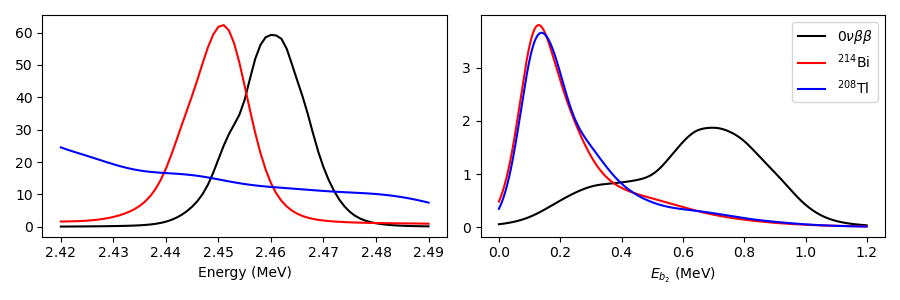

In [3]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_0nubb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_214Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_208Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel("Energy (MeV)")

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.001)
plt.plot(E, pdf_eblob2_0nubb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_214Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_208Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel(r"$E_{b_2}$ (MeV)")

plt.legend()
plt.tight_layout()

## Check by volume and background

In [36]:
import time
from invisible_cities.io.dst_io import load_dst, load_dsts
from invisible_cities.evm.mixer import get_file_number

def remove_spurious_tracks(tracks, spurious_energy):
    # remove spurious tracks and assign energy to largest energy track:
    # sum spurious track energies to max energy track and
    # correct numb_of_tracks values

    # tracks index must be (event, file) (ie levels 0 and 1)
    tracks = tracks.set_index("trackID", append=True)

    sel_spurious = (tracks.energy < spurious_energy)
    spurious_energies = tracks.loc[sel_spurious].groupby(level=[0, 1]).energy.sum()

    # trackID of max energy track
    trackID = tracks.reset_index(level=2).loc[spurious_energies.index] \
                    .set_index("trackID", append=True).groupby(level=[0, 1]) \
                    .apply(lambda df: df.energy.idxmax()[-1])
    trackID.name = "trackID"

    # sum spurious energy to max energy track
    spurious_energies = pd.merge(spurious_energies, trackID, left_index=True, right_index=True)\
                        .set_index("trackID", append=True)
    tracks.loc[spurious_energies.index, "energy"] += spurious_energies.energy

    # drop spurious
    tracks = tracks.loc[~sel_spurious].reset_index("trackID")
    # correct numb of tracks
    tracks.loc[:, "numb_of_tracks"] = tracks.groupby(level=[0, 1]).trackID.nunique()

    return tracks


def apply_cuts(tracks):
    
    # cuts

    # 1S1-1S2
    # included

    # spurious tracks
    tracks = remove_spurious_tracks(tracks.set_index(["event", "file"]), 0.01)

    # 1-track
    sel = tracks.numb_of_tracks == 1
    print("1track eff:", round(tracks.loc[sel].index.nunique()/tracks.index.nunique(), 3))
    tracks = tracks.loc[sel]

    # fiducial R<rmax
    sel = tracks.r_max<450
    print("fiducial eff:", round(tracks.loc[sel].index.nunique()/tracks.index.nunique(), 3))
    tracks = tracks.loc[sel]

    # overlap
    sel = tracks.ovlp_blob_energy == 0
    print("overlap eff:", round(tracks.loc[sel].index.nunique()/tracks.index.nunique(), 3))
    tracks = tracks.loc[sel]
#     # E > 2 MeV
#     tracks = tracks[tracks.energy>2]
    return tracks


def load_dsts_with_info(filenames, group, table):
    
    get_volume = lambda filename: filename.split("/")[-4]
    
    dst = pd.DataFrame()
    for f, filename in enumerate(filenames, 1):
        print(f"Processed {f} / {len(filenames)}", end="\r")
        try:
            dst_ = load_dst(filename, group, table)
        except:
#             print(filename)
            continue
        dst_.loc[:, "file"]     = get_file_number(filename)
        dst_.loc[:, "G4Volume"] = get_volume(filename)
        dst = pd.concat([dst, dst_])
    print()
    return dst

In [65]:
inpath = os.path.expandvars("$HOME/NEXT/DATA/production/{isotope}/{g4volume}/prod/isaura/isaura_*.h5")

isotope  = "208Tl"
g4volume = "EP_COPPER_PLATE"

filenames = sorted( glob.glob(inpath.format(isotope=isotope, g4volume=g4volume))
                  , key = get_file_number)[:2000]
t0 = time.time()

tracks = load_dsts_with_info(filenames, "Tracking", "Tracks")
tracks = apply_cuts(tracks)

print()
print("Time:", (time.time() - t0) / 60)

Processed 1181 / 1181
1track eff: 0.702
fiducial eff: 0.823
overlap eff: 0.99

Time: 1.029031797250112


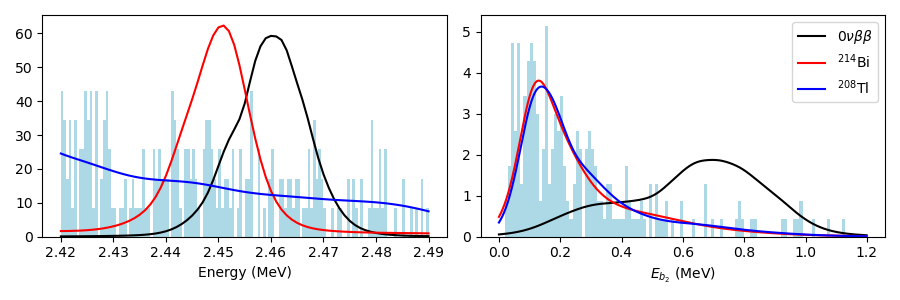

In [66]:
plt.figure(figsize=[9, 3])

plt.subplot(121)
E = np.arange(*energy_obs.limit1d, 0.001)
plt.plot(E, pdf_energy_0nubb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_energy_214Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_energy_208Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel("Energy (MeV)")

bins = np.arange(*energy_obs.limit1d, 0.0005)
plt.hist(tracks.energy, bins=bins, density=True, color="lightblue")

plt.subplot(122)
E = np.arange(*eblob2_obs.limit1d, 0.001)
plt.plot(E, pdf_eblob2_0nubb.pdf(E), color="k", label=r"$0\nu\beta\beta$")
plt.plot(E, pdf_eblob2_214Bi.pdf(E), color="r", label=r"$^{214}$Bi")
plt.plot(E, pdf_eblob2_208Tl.pdf(E), color="b", label=r"$^{208}$Tl")
plt.xlabel(r"$E_{b_2}$ (MeV)")

bins = np.arange(*eblob2_obs.limit1d, 0.01)
plt.hist(tracks[tracks.energy.between(*energy_obs.limit1d)].eblob2, bins=bins, density=True, color="lightblue")

plt.legend()
plt.tight_layout()